In [ ]:
import sys
!{sys.executable} -m pip install seaborn

In [1]:
import logging

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import azureml.core
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.16.0 of the Azure ML SDK


In [75]:
from azureml.core.authentication import InteractiveLoginAuthentication
auth = InteractiveLoginAuthentication(tenant_id = '7d9fdaba-a83f-43d1-8d9e-877fd1d8b9df')
ws = Workspace.from_config(auth = auth)

# choose a name for experiment
experiment_name = 'ml-dog_breeds-experiment'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,101c228b-7ec2-48c2-b9d3-f012863db5b7
Workspace,fkroes-ai-workspace
Resource Group,ai-resourcegroup
Location,westeurope
Experiment Name,ml-dog_breeds-experiment


# Create or Attach existing AmlCompute

A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

Creation of AmlCompute takes approximately 5 minutes.
If the AmlCompute with that name is already in your workspace this code will skip the creation process. As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [76]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "tf-compute-instance"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.

Running


# Data

In [77]:
df_labels = pd.read_csv("input/labels.csv")
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Add filepath to the DataFrame

In [6]:
df_labels['filename'] = df_labels.id.map(lambda id: f'input/data/train/{id}.jpg')
df_labels.head()

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,input/data/train/000bec180eb18c7604dcecc8fe0db...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,input/data/train/001513dfcb2ffafc82cccf4d8bbab...
2,001cdf01b096e06d78e9e5112d419397,pekinese,input/data/train/001cdf01b096e06d78e9e5112d419...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,input/data/train/00214f311d5d2247d5dfe4fe24b23...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,input/data/train/0021f9ceb3235effd7fcde7f7538e...


# Data exploration
Show what we are ourself getting self into ...

In [7]:
print(df_labels.describe())
print('')
print('----------------------------------------------------')
print('')
print(df_labels.breed.describe())

                                      id               breed  \
count                              10222               10222   
unique                             10222                 120   
top     d47ae5d9f7c17055130be743362f4bfd  scottish_deerhound   
freq                                   1                 126   

                                                 filename  
count                                               10222  
unique                                              10222  
top     input/data/train/841463629c4833816e216cbb041c2...  
freq                                                    1  

----------------------------------------------------

count                  10222
unique                   120
top       scottish_deerhound
freq                     126
Name: breed, dtype: object


In [8]:
unique_labels = df_labels.breed.unique()
print('Unique amount of labels', len(unique_labels))

Unique amount of labels 120


We have good news - all breeds are present in train dataset.

So lets calculate amount if images for every breed and check most frequent.

In [57]:
gr_labels = df_labels.groupby("breed").count()
gr_labels = gr_labels.rename(columns = {"id" : "count"})
gr_labels = gr_labels.sort_values("count", ascending=False)
gr_labels.head(10)
# gr_labels.tail()

,count,filename
breed,,
scottish_deerhound,126,126
maltese_dog,117,117
afghan_hound,116,116
entlebucher,115,115
bernese_mountain_dog,114,114
shih-tzu,112,112
great_pyrenees,111,111
pomeranian,111,111
basenji,110,110


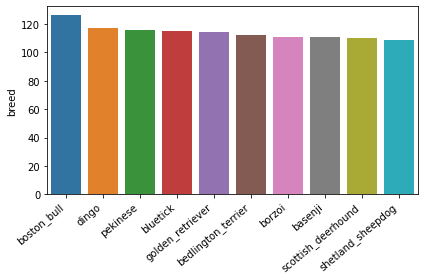

In [60]:
# plt.figure(figsize=(20,20))
ax = sns.barplot(x=df_labels.breed.unique()[:10], y=df_labels.breed.value_counts()[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()
plt.show()

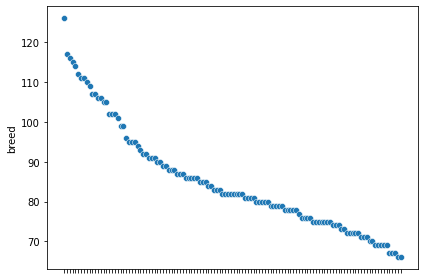

In [11]:
ax = sns.scatterplot(x=df_labels.breed.unique(), y=df_labels.breed.value_counts())
ax.set_xticklabels('')
plt.tight_layout()
plt.show()

# Data processing

In [12]:
[df_labels.filename.values.tolist()[:10]]

[['input/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'input/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'input/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'input/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'input/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  'input/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  'input/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  'input/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
  'input/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  'input/data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']]

Converting every image to a array of Tensors, with image size 256x256 pixels

In [14]:
from tqdm import tqdm

img_pixel = np.array([img_to_array(load_img(img, target_size=(224, 224))) for img in tqdm(df_labels.filename.values.tolist() ) ])

100%|██████████| 10222/10222 [00:27<00:00, 366.76it/s]


Converting image labels to auto-hot encoding

In [15]:
img_label = df_labels.breed
img_label = pd.get_dummies(df_labels.breed)
img_label.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
print('original label:', df_labels.breed.values[0])
print('index where label occurs in hot-encoding array:', img_label.values[0].argmax())
print()

print('there will be a 1 where the sample label occurs:')
print(img_label.values[0].astype(int))
# print(np.where(df_labels.breed.unique == img_label))

original label: boston_bull
index where label occurs in hot-encoding array: 19

there will be a 1 where the sample label occurs:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Creating the train numpy arrays (X)=images and (Y)=breed of image, therefore dog

In [17]:
X = img_pixel
y = img_label.values
print(X.shape)
print(y.shape)

(10222, 224, 224, 3)
(10222, 120)


In [18]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train.repeat()
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (8177, 224, 224, 3)
X_test: (2045, 224, 224, 3)
y_train: (8177, 120)
y_test: (2045, 120)


In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Takes data & label arrays, generates batches of augmented data.
train_generator = train_datagen.flow(x=X_train, y=y_train, batch_size=32, seed=42)

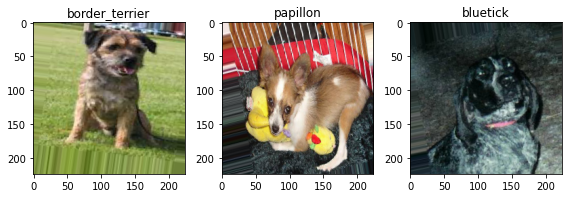

In [22]:
plt.figure(figsize=(8,8))
for image in range(0, 3):
    plt.subplot(1, 3, image+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.title(img_label.columns[Y_batch[0].argmax()])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)

# Takes data & label arrays, generates batches of augmented data.
validation_generator = validation_datagen.flow(x=X_test, y=y_test, batch_size=32, seed=42)

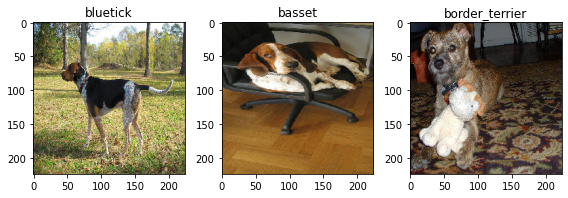

In [24]:
plt.figure(figsize=(8,8))
for image in range(0, 3):
    plt.subplot(1, 3, image+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.title(img_label.columns[Y_batch[0].argmax()])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Train on Microsoft Azure Machine Learning

With this section of the notebook, we are going to define what and how we are going to train a model on a Azure Machine Learning cloud service. We are going to do this by leveraging the Azure SDK and therefore their capabilities.

In [79]:
from azureml.core import Dataset, Datastore


{
  "source": [
    "('workspaceblobstore', 'input/data/train')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

DatasetValidationError: DatasetValidationError:
	Message: Cannot load any data from the specified path. Make sure the path is accessible and contains data.
ScriptExecutionException was caused by StreamAccessException.
  StreamAccessException was caused by NotFoundException.
    Found no resources for the input provided: '[REDACTED]'
| session_id=a2c0cbe5-b2ff-4da3-a110-5dd37be263b5
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Cannot load any data from the specified path. Make sure the path is accessible and contains data.\nScriptExecutionException was caused by StreamAccessException.\n  StreamAccessException was caused by NotFoundException.\n    Found no resources for the input provided: '[REDACTED]'\n| session_id=a2c0cbe5-b2ff-4da3-a110-5dd37be263b5"
    }
}

In [86]:
training_data, validation_data = dogs_ds.random_split(percentage=0.8, seed=42)
label_column_name = 'breed'

In [90]:
automl_settings = {
    "primary_metric": 'average_precision_score_weighted',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2, # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_hours": 0.25, # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(
    task = 'classification',
    debug_log = 'automl_errors.log',
    compute_target = compute_target,
    training_data = training_data,
    label_column_name = label_column_name
)

# automl_config = AutoMLConfig(task='classification', debug_log='automl_errors.log', compute_target=compute_target, X=X_train, y=y_train, X_valid=X_test, y_valid=y_test)

In [91]:
remote_run = experiment.submit(automl_config, show_output=False)

ConfigException: ConfigException:
	Message: Input of type 'Unknown' is not supported. Supported types: [azureml.data.tabular_dataset.TabularDataset, azureml.pipeline.core.pipeline_output_dataset.PipelineOutputTabularDataset]
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Input of type 'Unknown' is not supported. Supported types: [azureml.data.tabular_dataset.TabularDataset, azureml.pipeline.core.pipeline_output_dataset.PipelineOutputTabularDataset]",
        "details_uri": "https://aka.ms/AutoMLConfig",
        "target": "training_data",
        "inner_error": {
            "code": "BadArgument",
            "inner_error": {
                "code": "ArgumentInvalid",
                "inner_error": {
                    "code": "InvalidInputDatatype"
                }
            }
        }
    }
}

In [ ]:
remote_run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

In [ ]:
remote_run.wait_for_completion(show_output=True)

In [ ]:
# Analyze results via Azure Portal

In [ ]:
# WRITE HERE 

# Train on TensorFlow (locally)

For the record. You can also run this in the cloud. But in case you are running this in Azure, I would recommend to run the previous part, there we are levering the Azure Cloud SDK.

# Building the model

Before we can build the model, there are a few things we need to define:

- The input shape (images, in the form of Tensors) to our model
- The output shape (image labels, in the form of Tensors) of our model
- The URL of the model we want to use (because of Transfer Learning)

In [25]:
# Setup input shape to the model
INPUT_SHAPE = [None, 224, 224, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(df_labels.breed.unique()) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [26]:
import tensorflow
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, ZeroPadding2D, Flatten, Dropout, MaxPooling2D

In [36]:
def create_model_transfer_learning(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # setup the model layers
    model = Sequential([hub.KerasLayer(MODEL_URL), Dense(units=OUTPUT_SHAPE, activation='softmax')])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.build(INPUT_SHAPE)

    return model

def create_model_scratch(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building own made model")

    model = Sequential()
    model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(224, 224, 3)))

    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
model = create_model_transfer_learning()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [38]:
own_model = create_model_scratch()
own_model.summary()

Building own made model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_5 (Dense)              (

# Creating callbacks (things to help our model)
We've got a model ready to go but before we train it we'll make some callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progres, check a models progress or stop training early if a model stops improving.

## Tensorboard Callback

TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notbook, we need to do three things:

1. Load the TensorBoard notebook extension.

2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.

3. Visualize the our models trainigs logs using %tensorboard magic function (we'll do this later on)

In [44]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [46]:
import datetime
import os

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directly for storing TensorBoard logs
    logdir = os.path.join('logs', datetime.datetime.now().strftime('%d%m%Y-%H%M%S'))

    return tensorflow.keras.callbacks.TensorBoard(logdir=logdir)

## Early Stopping Callback

Early stopping helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

Therefore, when there is not enough change in our model, we can say that the model have reached a equilibrium.

In [47]:
# Create early stopping (once our model stops improving, stop training)
# it stops after 3 rounds of no improvements
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

## Training a model

The final parameter we'll define before training is NUM_EPOCHS (also known as number of epochs).

NUM_EPOCHS defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If NUM_EPOCHS=1, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for NUM_EPOCHS?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set NUM_EPOCHS to 100 but our model stops improving after 22 epochs, it'll stop training.

In [49]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100

Create a model using create_model().

Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).

Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.

Return the fitted model.

In [50]:
def train_model():
    # Trains a given model and returns the trained version

    model = create_model()

    tensorboard = create_tensorboard_callback()

    model.fit_generator(
        generator=train_generator, 
        # steps_per_epoch= X_train.shape[0] // 32, 
        validation_data=validation_generator, 
        validation_freq=1,  
        # validation_steps= y_train.shape[0] // 32,
        epochs=NUM_EPOCHS, 
        verbose=1,
        callbacks=[tensorboard, early_stopping])

    return model

In [42]:
model = train_model()

Epoch 1/15
256/256 [==============================] - 144s 562ms/step - loss: 1.7819 - accuracy: 0.5696 - val_loss: 0.8318 - val_accuracy: 0.7623
Epoch 2/15
256/256 [==============================] - 142s 555ms/step - loss: 0.7058 - accuracy: 0.7887 - val_loss: 0.7766 - val_accuracy: 0.7648
Epoch 3/15
256/256 [==============================] - 144s 564ms/step - loss: 0.5430 - accuracy: 0.8270 - val_loss: 0.7761 - val_accuracy: 0.7677
Epoch 4/15
256/256 [==============================] - 144s 562ms/step - loss: 0.4293 - accuracy: 0.8612 - val_loss: 0.7630 - val_accuracy: 0.7707
Epoch 5/15
256/256 [==============================] - 143s 557ms/step - loss: 0.3740 - accuracy: 0.8780 - val_loss: 0.7839 - val_accuracy: 0.7741
Epoch 6/15
256/256 [==============================] - 143s 557ms/step - loss: 0.3204 - accuracy: 0.8968 - val_loss: 0.7881 - val_accuracy: 0.7804
Epoch 7/15
256/256 [==============================] - 146s 570ms/step - loss: 0.2883 - accuracy: 0.9084 - val_loss: 0.8214 -

# Checking the TensorBoard logs

Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and viualize its contents.

In [52]:
%tensorboard --logdir logs